## Importing the required libraries

In [2]:
import json
from PIL import Image
import numpy as np
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import os
import matplotlib.pyplot as plt
import cv2
import random
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Downloading dataset from google drive

In [4]:
from google.colab import drive
import os
drive.mount('/content/drive')
!mkdir 'Gorilla_dataset'
!unzip 'drive/MyDrive/Segment_Gorilla.zip' -d '/content/Gorilla_dataset'

Mounted at /content/drive
Archive:  drive/MyDrive/Segment_Gorilla.zip
   creating: /content/Gorilla_dataset/test/
   creating: /content/Gorilla_dataset/test/images/
  inflating: /content/Gorilla_dataset/test/images/gori_44.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_42.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_46.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_48.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_43.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_45.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_49.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_47.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_41.jpg  
  inflating: /content/Gorilla_dataset/test/images/gori_50.jpg  
   creating: /content/Gorilla_dataset/test/masks/
  inflating: /content/Gorilla_dataset/test/masks/gori_41.png  
  inflating: /content/Gorilla_dataset/test/masks/gori_46.png  
  inflating: /conte

## Exploring the dataset

In [66]:
data_dir = '/content/Gorilla_dataset/'
train_dir = data_dir + 'train/'
test_dir = data_dir + 'test/'

for dir in os.listdir(data_dir):
    if os.path.isdir(data_dir+dir):
        print('{}:'.format(dir))
        for sdir in os.listdir(data_dir + dir):
            print('\t {} - {} items'.format(sdir,str(len(os.listdir(data_dir + dir+'/' +sdir)))))

train:
	 masks - 40 items
	 images - 40 items
test:
	 masks - 10 items
	 images - 10 items


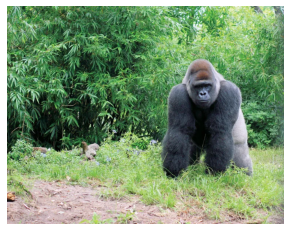

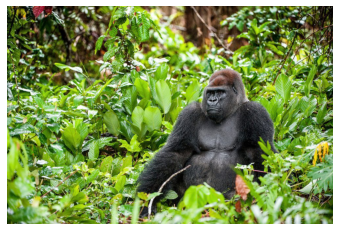

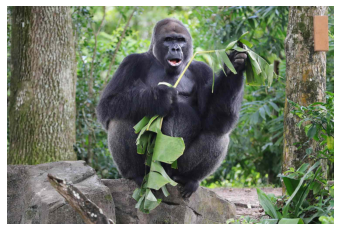

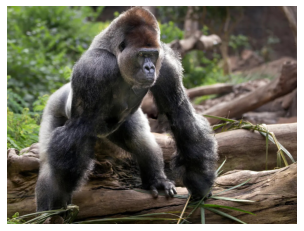

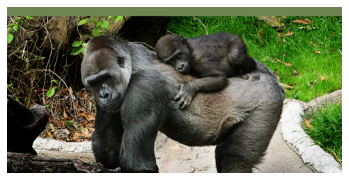

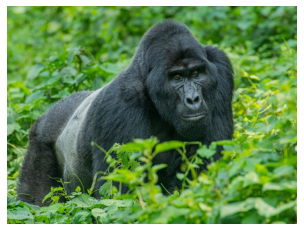

In [67]:
for i in range(9,15):
  img = Image.open(train_dir+'/images/gori_'+str(i)+'.jpg')
  plt.axis("off")
  plt.imshow(img)
  plt.show()


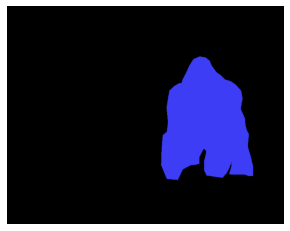

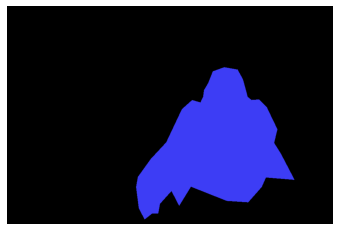

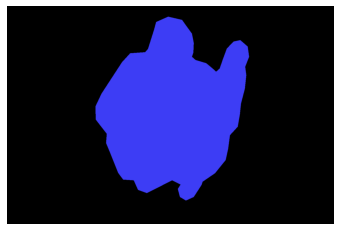

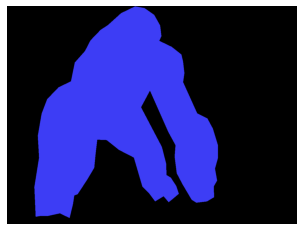

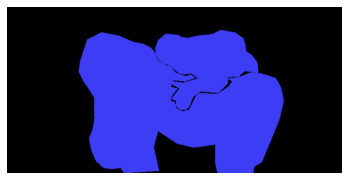

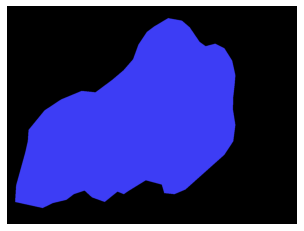

In [68]:
for i in range(9,15):
  img = Image.open(train_dir+'/masks/gori_'+str(i)+'.png')
  plt.axis("off")
  plt.imshow(img)
  plt.show()


## clone some helping functions

In [69]:
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.8.2
!cp references/detection/utils.py ../
!cp references/detection/transforms.py ../
!cp references/detection/coco_eval.py ../
!cp references/detection/engine.py ../
!cp references/detection/coco_utils.py ../
%cd ../
cwd = os.getcwd()
print(cwd)

fatal: destination path 'vision' already exists and is not an empty directory.
/content/vision
HEAD is now at 2f40a483d [v0.8.X] .circleci: Add Python 3.9 to CI (#3063)
/content
/content


In [142]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [143]:
class GorillaDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, 'images'))))
        self.masks = list(sorted(os.listdir(os.path.join(root, 'masks'))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, 'images', self.imgs[idx])
        mask_path = os.path.join(self.root, 'masks', self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path).convert('L')
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes # the coordinates of the N bounding boxes in [x0, y0, x1, y1] format, ranging from 0 to W and 0 to H
        target["labels"] = labels # the label for each bounding box
        target["masks"] = masks # The segmentation masks for each one of the objects
        target["image_id"] = image_id # an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
        target["area"] = area # The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
        target["iscrowd"] = iscrowd #  instances with iscrowd=True will be ignored during evaluation.

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## Select the model

In [144]:
# version dependent: pretrained=True or weights='DEFAULT'      
def build_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Stop here if you are fine-tunning Faster-RCNN

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

## load and split the dataset

In [145]:
train_dataset = GorillaDataset(train_dir, get_transform(train=True))
valid_dataset = GorillaDataset(test_dir, get_transform(train=False))
torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

valid_data_loader= torch.utils.data.DataLoader(
    valid_dataset, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [146]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
print(f'device: {device}')

# our dataset has two classes only - background and cube
num_classes = 2
CLASS_NAMES = ['__background__', 'Gorilla']

model = build_model(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0007)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

device: cuda:0


## Training

In [147]:
# number of epochs
num_epochs = 25

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [ 0/20]  eta: 0:00:11  lr: 0.000027  loss: 7.2786 (7.2786)  loss_classifier: 0.4905 (0.4905)  loss_box_reg: 0.1705 (0.1705)  loss_mask: 6.6149 (6.6149)  loss_objectness: 0.0012 (0.0012)  loss_rpn_box_reg: 0.0014 (0.0014)  time: 0.5985  data: 0.0480  max mem: 11669
Epoch: [0]  [10/20]  eta: 0:00:06  lr: 0.000290  loss: 2.7758 (3.7660)  loss_classifier: 0.4375 (0.3966)  loss_box_reg: 0.1290 (0.1369)  loss_mask: 2.2584 (3.2192)  loss_objectness: 0.0018 (0.0036)  loss_rpn_box_reg: 0.0038 (0.0096)  time: 0.6825  data: 0.1006  max mem: 11669
Epoch: [0]  [19/20]  eta: 0:00:00  lr: 0.000500  loss: 1.0589 (2.4196)  loss_classifier: 0.2067 (0.2676)  loss_box_reg: 0.1222 (0.1220)  loss_mask: 0.7137 (2.0094)  loss_objectness: 0.0027 (0.0082)  loss_rpn_box_reg: 0.0093 (0.0124)  time: 0.7123  data: 0.1265  max mem: 11669
Epoch: [0] Total time: 0:00:14 (0.7125 s / it)
creating index...
index created!
Test:  [ 0/10]  eta: 0:00:01  model_time: 0.0911 (0.0911)  evaluator_time: 0.0191 (0.0191

## Saving the model

In [148]:
if os.path.isdir('maskrcnn_weights')==False: os.mkdir('maskrcnn_weights') 
torch.save(model, 'maskrcnn_weights/mask-rcnn-gorilla.pt')
torch.save(model.state_dict(), 'maskrcnn_weights/mask-rcnn-gorilla_weights.pt') 
model.load_state_dict(torch.load('/content/maskrcnn_weights/mask-rcnn-gorilla_weights.pt'))

<All keys matched successfully>

## Evaluating the model

In [149]:
model.eval()
CLASS_NAMES = ['__background__', 'Gorilla']
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [150]:
import torchvision.transforms as T

def get_coloured_mask(mask):
    """
    random_colour_masks
      parameters:
        - image - predicted masks
      method:
        - the masks of each predicted object is given random colour for visualization
    """
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    r[mask == 1], g[mask == 1], b[mask == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask

def get_prediction(img_path, confidence):
    """
    get_prediction
      parameters:
        - img_path - path of the input image
        - confidence - threshold to keep the prediction or not
      method:
        - Image is obtained from the image path
        - the image is converted to image tensor using PyTorch's Transforms
        - image is passed through the model to get the predictions
        - masks, classes and bounding boxes are obtained from the model and soft masks are made binary(0 or 1) on masks
          ie: eg. segment of cat is made 1 and rest of the image is made 0
    
    """
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    img = img.to(device)
    pred = model([img])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>confidence][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # print(pred[0]['labels'].numpy().max())
    pred_class = [CLASS_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return masks, pred_boxes, pred_class

def segment_instance(img_path, confidence=0.5, rect_th=2, text_size=1, text_th=2):
    """
    segment_instance
      parameters:
        - img_path - path to input image
        - confidence- confidence to keep the prediction or not
        - rect_th - rect thickness
        - text_size
        - text_th - text thickness
      method:
        - prediction is obtained by get_prediction
        - each mask is given random color
        - each mask is added to the image in the ration 1:0.8 with opencv
        - final output is displayed
    """
    masks, boxes, pred_cls = get_prediction(img_path, confidence)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
      rgb_mask = get_coloured_mask(masks[i])
      img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        
      #cv2.rectangle and cv2.putText version dependent
      pt1 = tuple([int(j) for j in boxes[i][0]])
      pt2 = tuple([int(j) for j in boxes[i][1]])  
      cv2.rectangle(img, pt1, pt2,color=(0, 255, 0), thickness=rect_th)
      cv2.putText(img,pred_cls[i], pt1, cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

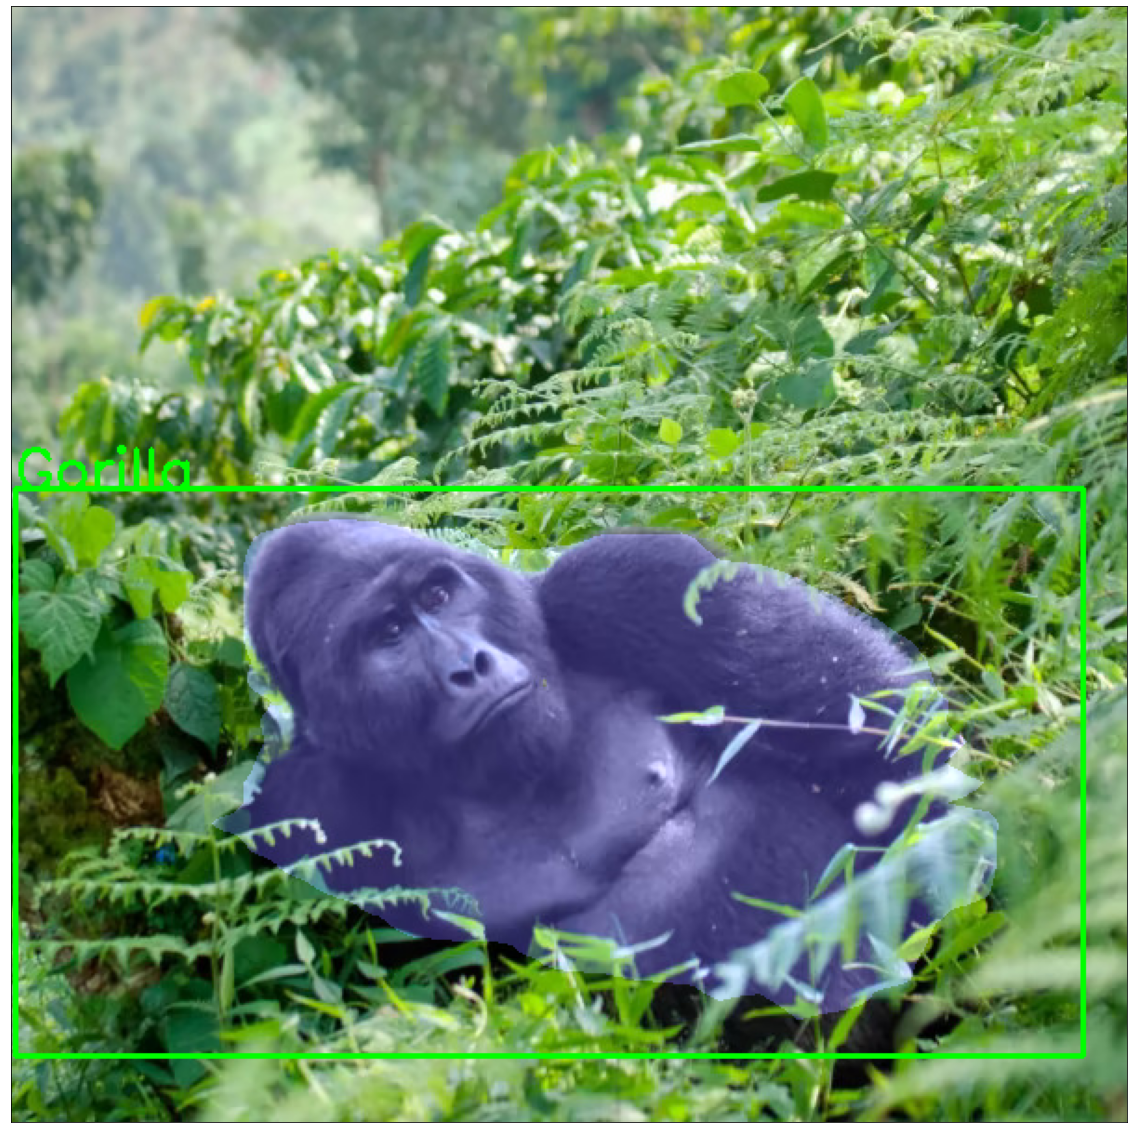

In [154]:
segment_instance('/content/Gorilla_dataset/test/images/gori_41.jpg', confidence=0.7)

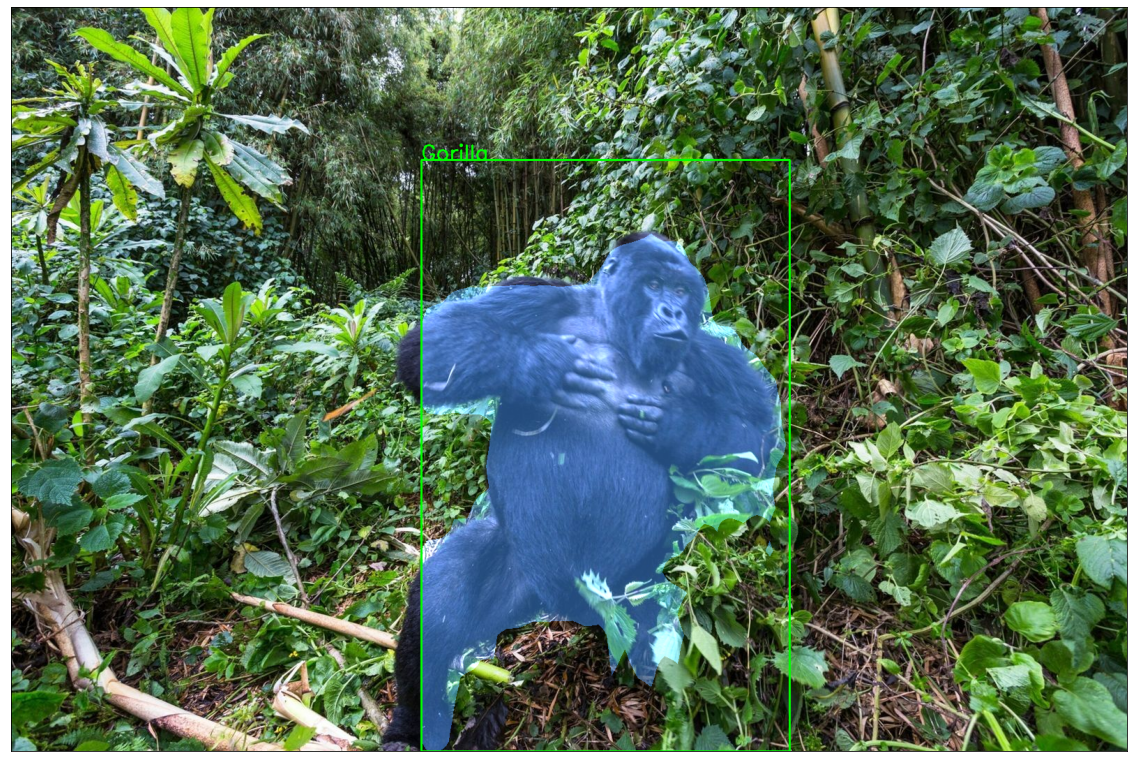

In [161]:
segment_instance('/content/Gorilla_dataset/test/images/gori_45.jpg', confidence=0.7)

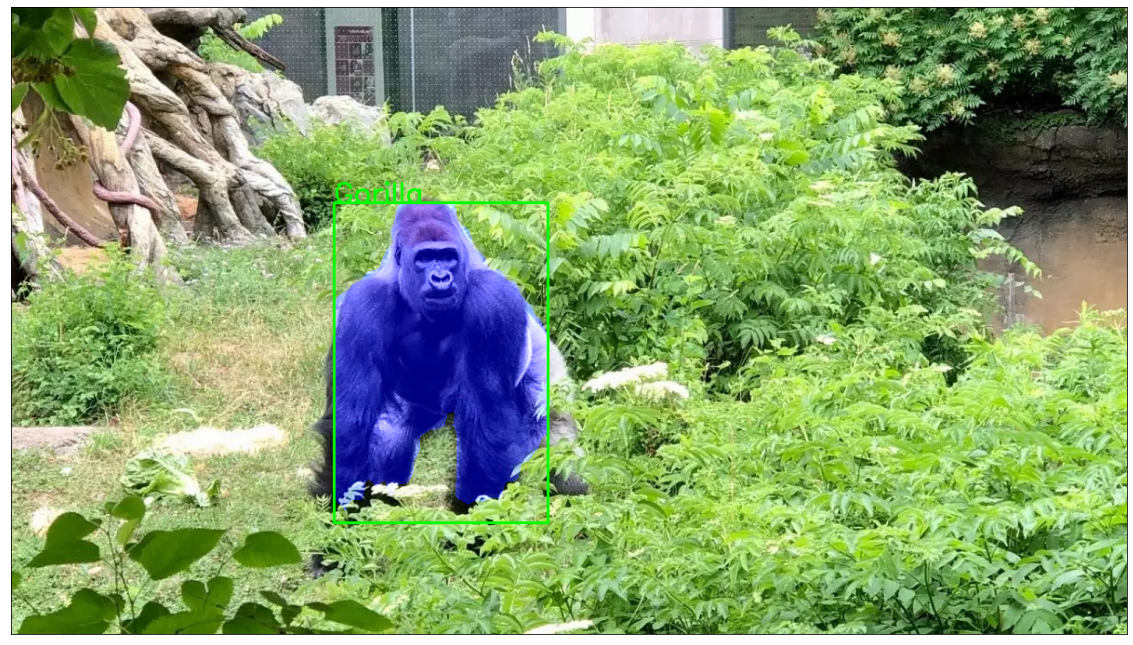

In [167]:
segment_instance('/content/Gorilla_dataset/test/images/gori_47.jpg', confidence=0.7)

### The model performed well on the Gorilla dataset, it was not very accurate in some cases but we can change that by adding more data in the training process